# Dark Matter Mass in a distant Galaxy

## Finding the radius-velocity curve

We first calculate the differences in RA and DEC of each star w.r.t the galactic centre, then converting all degree and arcsecond measures to radians. <br>$1 mas$ is converted to radians as follows: $$1 mas=10^{-3} " =\frac{10^{-3}}{3600} deg=\frac{10^{-3}}{3600} \frac{\pi}{180} rad\approx4.848 \times 10^{-9}rad$$


In [1]:
import pandas as pd
import math 

df=pd.read_csv('/home/ambica/Downloads/ksp2023-ami-ace-master/darkmatter.csv')
pd.options.mode.chained_assignment = None


#Coordinates of galaxy centre in radians
ra_centre=(math.pi)*140.763980/180
dec_centre=(math.pi)*75.53440/180

#Convert all degree and arcsec measures to radians
df['rel_RA(radians)']=(math.pi*(df['RA (degrees)']-140.76398))/180
df['rel_Dec(radians)']=(math.pi*(df['Dec (degrees)']-75.5344))/180
df['Proper Motion(rad/year)']=df['Proper Motion (milliarcseconds/year)']*4.848*10**(-9)

## Finding the relative velocities
We first find the radial velocity of the galaxy centre using Hubble's Law that relates the recessional velocity to the radial distance from the observer. Given that the galaxy is $3500 kpc$ away, $$v_{centre,radial}=H_0d=70 \frac{km}{s.Mpc} \times 3500kpc = 245000 m/s$$
Following this we use the expression for redshift,$ z = \sqrt{\frac{c+v}{c-v}} - 1$, to calculate the radial velocities of stars. Relative radial velocity can be approximated using $v-v_{centre,radial}$ since the line-of-sight for both the star and the galactic centre are almost aligned.<br>
_This may not be the case if the star is too far away from the galaxy, but those stars will be eliminated independently of these velocities later on,so this isn't really a concern here, except for perhaps time and memory._
<br>
Assuming that the observation is edge-on,tangential velocity is approximated using $3500 kpc \times \dot{\theta}$, where $\dot{\theta}$ is the proper motion.



In [2]:
#Find the radial velocity of the galaxy centre
vcentre=3500*70

#Find the radial velocity of stars w.r.t centre along line of sight in m/s
df['v_rad']=(3*10**8)*(((1+df['Redshift'])*(1+df['Redshift'])-1)/((1+df['Redshift'])*(1+df['Redshift'])+1))-vcentre

In [3]:
#Find the tangential velocity of stars in m/s
df['v_tan']= ((3500*1000*3.083*10**16)*df['Proper Motion(rad/year)'])/(365*24*3600)

## Calculation of Angular Separation and Tangential Separation

The formula used for angular separation is the following:$$\cos^{-1}(\sin(\delta_1)\sin(\delta_2)+\cos(\delta_1)\cos(\delta_2)\cos(\delta_1-\delta_2))$$ <br>
(RA,DEC) of star=$(\alpha_2, \delta_2)$<br>
(RA,DEC) of galaxy centre=$(\alpha_1, \delta_1)$<br>
Tangential separation is found using $3500 kpc \times$ Angular Separation<br>
Lastly, possible outliers are eliminated from the data(it was mentioned that few stars don't belong to the galaxy). The diameter of galaxies usually ranges between $10-100 kpc$ so only stars lying within this region are retained in the dataframe.

In [4]:
#Initialise a column for angular separation from galaxy centre to star
df['ang_sep']=df['Redshift']
print(df)
#Function to compute angular separation
def angsep(ra,dec):
    diff=ra-ra_centre
    a= math.acos(math.sin(dec_centre)*math.sin(dec)+math.cos(dec_centre)*math.cos(dec)*math.cos(diff))
    return a


#Fill the column with corresponding angular separation
for i in df.index.values:
    df['ang_sep'][i]=angsep((df['RA (degrees)'][i])*math.pi/180,df['Dec (degrees)'][i]*math.pi/180)

#Use angular separation to find tangential separation.
df['tan_sep(kpc)']=3500*df['ang_sep']

#Eliminate stars not in the galaxy. 
df=df[df['tan_sep(kpc)']<=50]

     RA (degrees)  Dec (degrees)  Proper Motion (milliarcseconds/year)  \
0      142.050932      75.723859                              0.005518   
1      140.197408      75.431869                             -0.006326   
2      140.940682      75.557226                             -0.009085   
3      140.389026      75.475242                             -0.002282   
4      140.890018      75.553727                             -0.007875   
..            ...            ...                                   ...   
532    128.342583      60.218765                            -66.839992   
533    135.323604      67.753321                             32.055615   
534    155.661474      80.795780                             39.969126   
535    120.679878      67.082195                            -91.455362   
536    162.670129      74.154174                             25.493489   

     Redshift  rel_RA(radians)  rel_Dec(radians)  Proper Motion(rad/year)  \
0    0.001227         0.022462    

## Total Velocity, Radial Separation and Distance from Centre
$$v=\sqrt{v_{rad}^2+v_{tan}^2}$$
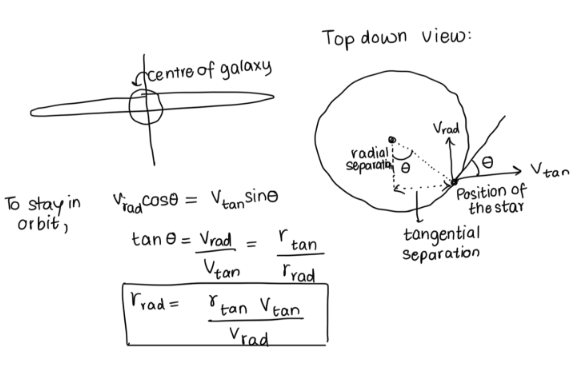
$$r=\sqrt{tan-sep^2+rad-sep^2}$$

In [5]:
df['v']=((df['v_rad'])**2+(df['v_tan'])**2)**0.5
df['rad_sep(kpc)']=((df['tan_sep(kpc)'])*(df['v_tan']))/(df['v_rad'])
df['Distance from centre(kpc)']=((df['tan_sep(kpc)'])**2+(df['rad_sep(kpc)'])**2)**0.5

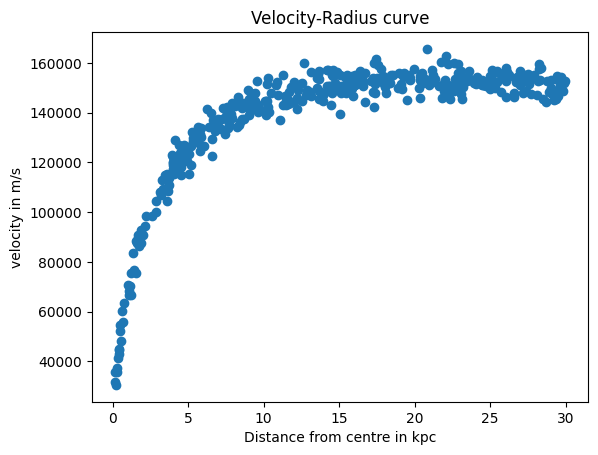

In [6]:
import matplotlib.pyplot as plt
plt.scatter(df['Distance from centre(kpc)'],df['v'])
plt.xlabel('Distance from centre in kpc')
plt.ylabel('velocity in m/s')
plt.title('Velocity-Radius curve')
plt.show()

## Finding halo parameters using the curve

The **galaxy rotation curve** is obtained,its a curve that rises steeply first, curves and becomes almost constant from around midway. This rotation curve is evidence for the dark matter halo. The halo is taken to be spherical with the centre at galaxy's centre, with radial density profile given by the [Navarro-Frenk-White (NFW) profile](https://en.wikipedia.org/wiki/Navarro%E2%80%93Frenk%E2%80%93White_profile):

$$ \rho (r) = \frac{\rho_0}{\frac{r}{R_s}\left( 1 + \frac{r}{R_s}\right)^2} $$

where $R_s$ is a scale radius whose value is comparable to the radius of the galaxy (i.e. same order of magnitude).

From the density profile, we find the expression for mass $M_r$ enclosed in a sphere of radius $r$.




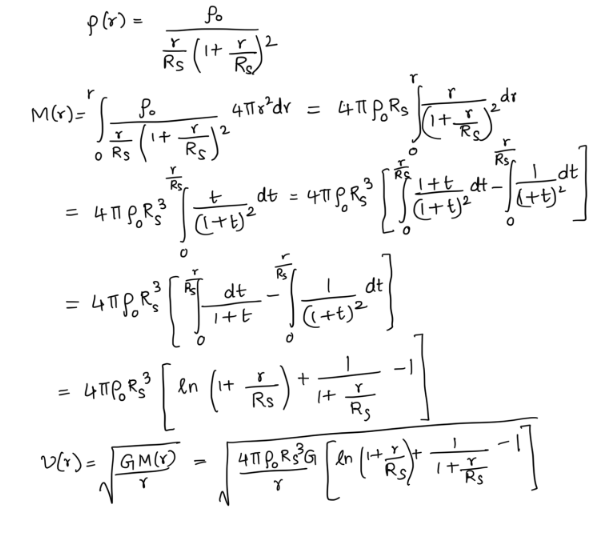

Subsequently we find the best fit value of  $R_s$,given that the value of $\rho_0$ is $0.02$ solar masses per cubic parsec.<br>
$\rho_0 = \frac{0.02 \times (2 \times 10^{30} kg)}{(3.083 \times 10^{16} m)^3}$ SI Units <br>$= 1.365\times 10^{-21} $SI Units <br>
Note that the initial guess passed onto the curve-fit function is 1 kpc in order to avoid errors in estimating $R_s$

In [7]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

#Convert the dataframe columns to numpy arrays
r=df['Distance from centre(kpc)'].to_numpy()
#Convert to SI
r=r*3.083*10**19
v=df['v'].to_numpy()

#Gravitational Constant and p_0
G=6.673*10**-11 
p=1.365*10**-21
    
def velocity(r,R_s):
    return (((4*math.pi*p*G*R_s**3)/r)*((np.log(1+(r/R_s)))+(1/(1+(r/R_s)))-1))**0.5


#Use the curve fit with an initial guess of 1 kpc to find the best fit value of R_S, contained in params
params, covs=curve_fit(velocity,r,v,p0=10**19)
params

array([3.07837936e+20])

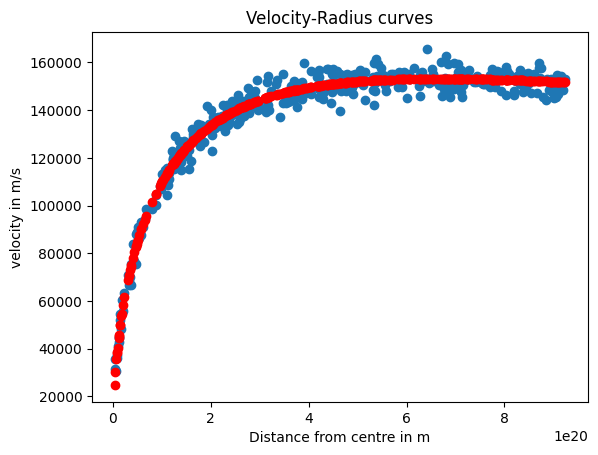

In [8]:
#Define a final expression for v in terms of R_s as calculated above
final_function= (((4*math.pi*p*G*params[0]**3)/r)*((np.log(1+(r/params[0])))+(1/(1+(r/params[0])))-1))**0.5

plt.scatter(r,final_function,color='red',zorder=10)
plt.plot(r,df['v'],'o',zorder=0)
plt.xlabel('Distance from centre in m')
plt.ylabel('velocity in m/s')
plt.title('Velocity-Radius curves')
plt.show()

## Calculation of Virial Radius

Define the virial radius to be the radius at which the mean density of the galaxy equals $50$ times the background density of the universe(i.e. $8.5 \times 10^{-27}$ SI Units). Following is a function to calculate mean density at a distance x from the galactic centre and the mean density at $x=50R_s$

In [9]:
R_s=params[0]

#Function to calculate mean density for a radius x
def mean_Density(x):
    return ((3*p*((R_s)**3))*((math.log(1+(x/R_s)))+(1/(1+(x/R_s)))-1)/x**3)

#Find the mean density at the required location
x=50*R_s
print(mean_Density(x))    

9.668896066922536e-26


We tweak around with a few values of radius in the mean density function till we get a density close to 50 times the background density, then rounding off to the nearest multiple of $10R_s$.

In [10]:
#Print density at virial radius
bd=8.5*10**-27
density_rv=50*bd
print(density_rv)

#Virial radius, obtained by trial and error.
vr=28.5*R_s
print(mean_Density(vr))   

"""
VIRIAL RADIUS =30*R_s
"""

4.25e-25
4.277868683037903e-25


'\nVIRIAL RADIUS =30*R_s\n'

Using this virial radius, we find the total mass contained inside the sphere i.e. the mass of dark matter in the galaxy

In [11]:
#Total mass contained in the sphere in kg
volume = (4*math.pi*(vr)**3)/3
print(mean_Density(vr)*volume)

1.2100882723456773e+42


## Final Results
 
 ### $R_s=3.08 \times 10^{20} m$
 ### $Dark Matter Mass=1.21 \times 10^{42} kg$
 ### $Virial Radius \approx 9.23 \times 10^{21} m$